In [ ]:
import tensorflow as tf
# tf.enable_eager_execution()
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# from hilbert import hilbertCurve
import imgaug.augmenters as iaa
import numpy as np
# import albumentations as A
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, CuDNNLSTM, BatchNormalization, ReLU, Reshape
from tensorflow.keras.models import Model
import random as rn

In [ ]:
#!pip install imgaug

In [ ]:
from tensorflow.keras.layers import Flatten

In [ ]:
# here dir_path is the route directory where all the images and segmentation maps are there
dir_path = "900_images"
file_names = set()
for i in os.listdir(dir_path):
    file_names.add(i.split('.')[0])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(list(file_names), test_size=0.33, random_state=42)

In [ ]:
#!pip install -U segmentation-models==0.2.1

In [ ]:
# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models import Unet
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

In [ ]:
# loading the unet model and using the resnet 34 and initilized weights with imagenet weights
# "classes" :different types of classes in the dataset
model = Unet('resnet34', encoder_weights='imagenet', classes=1, activation='sigmoid', input_shape=(512,512,3))

In [ ]:
model.summary()

Model: "u-resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 512, 512, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 518, 518, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 256, 256, 64) 9408        zero_padding2d_1[0][0]           
_________________________________________________________________________________________

In [ ]:
# import imgaug.augmenters as iaa
# For the assignment choose any 4 augumentation techniques
# check the imgaug documentations for more augmentations
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [ ]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()
    
def normalize_image(mask):
    mask = mask/255
    return mask

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = ['edited','non-edited']
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, images_dir, file_names):
        
        self.ids = file_names
        # the paths of images
        self.images_fps   = [os.path.join(images_dir, image_id+'.jpg') for image_id in self.ids]
        # the paths of segmentation images
        self.masks_fps    = [os.path.join(images_dir, image_id+".mask.jpg") for image_id in self.ids]
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        image_mask = normalize_image(mask)

        
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        a = np.random.uniform()
        if a<0.2:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        elif a<0.4:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
        elif a<0.6:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
        elif a<0.8:
            image = aug5.augment_image(image)
            image_mask = image_mask
        else:
            image = aug6.augment_image(image)
            image_mask = aug6.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet

optim = tf.keras.optimizers.Adam(0.0001)

focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

model.compile(optim, focal_loss, metrics=[iou_score])

In [ ]:
# Dataset for train images
CLASSES = ['edited']
train_dataset = Dataset(dir_path,X_train, classes=CLASSES)
test_dataset  = Dataset(dir_path,X_test, classes=CLASSES)

BATCH_SIZE=1
train_dataloader = Dataloder(train_dataset, batch_size=1, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, 1)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, \
                                       mode='min', monitor='val_iou_score'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2),
]

(1, 512, 512, 3)


In [ ]:
history = model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=200,\
                              validation_data=test_dataloader,callbacks=callbacks, )

Epoch 1/200
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
301/301 [==============================] - 74s 247ms/step - loss: 1.4808 - iou_score: 0.0136 - f1-score: 0.0225 - val_loss: 1.4031 - val_iou_score: 1.7106e-04 - val_f1-score: 3.4129e-04
Epoch 2/200
301/301 [==============================] - 45s 149ms/step - loss: 1.3072 - iou_score: 0.0067 - f1-score: 0.0068 - val_loss: 1.3876 - val_iou_score: 2.8040e-04 - val_f1-score: 5.5249e-04
Epoch 3/200
301/301 [==============================] - 47s 156ms/step - loss: 1.2884 - iou_score: 0.0100 - f1-score: 0.0100 - val_loss: 1.3665 - val_iou_score: 4.4059e-06 - val_f1-score: 8.8026e-06
Epoch 4/200
301/301 [==============================] - 45s 150ms/step - loss: 1.2594 - iou_score: 0.0106 - f1-score: 0.0111 - val_loss: 1.3860 - val_iou_score: 0.0037 - val_f1-score: 0.0062
Epoch 5/200
301/301 [==============================] - 45s 151ms/step - loss: 1.2340 - iou_score: 0.0701 - f1-score: 0.101

301/301 [==============================] - 45s 150ms/step - loss: 0.9451 - iou_score: 0.3219 - f1-score: 0.4191 - val_loss: 1.5256 - val_iou_score: 0.0388 - val_f1-score: 0.0644
Epoch 43/200
301/301 [==============================] - 45s 150ms/step - loss: 0.9455 - iou_score: 0.3186 - f1-score: 0.4113 - val_loss: 1.4717 - val_iou_score: 0.0348 - val_f1-score: 0.0587
Epoch 44/200
301/301 [==============================] - 45s 150ms/step - loss: 0.9258 - iou_score: 0.3426 - f1-score: 0.4379 - val_loss: 1.5125 - val_iou_score: 0.0377 - val_f1-score: 0.0609
Epoch 45/200
301/301 [==============================] - 45s 150ms/step - loss: 0.9153 - iou_score: 0.3571 - f1-score: 0.4482 - val_loss: 1.5019 - val_iou_score: 0.0407 - val_f1-score: 0.0625
Epoch 46/200
301/301 [==============================] - 45s 150ms/step - loss: 0.9206 - iou_score: 0.3464 - f1-score: 0.4394 - val_loss: 1.5282 - val_iou_score: 0.0444 - val_f1-score: 0.0684
Epoch 47/200
301/301 [==============================] - 45

Epoch 85/200
301/301 [==============================] - 45s 150ms/step - loss: 0.7177 - iou_score: 0.5046 - f1-score: 0.5955 - val_loss: 1.6130 - val_iou_score: 0.0379 - val_f1-score: 0.0603
Epoch 86/200
301/301 [==============================] - 45s 150ms/step - loss: 0.7036 - iou_score: 0.5194 - f1-score: 0.5969 - val_loss: 1.5434 - val_iou_score: 0.0332 - val_f1-score: 0.0527
Epoch 87/200
301/301 [==============================] - 45s 150ms/step - loss: 0.7055 - iou_score: 0.5185 - f1-score: 0.6027 - val_loss: 1.6334 - val_iou_score: 0.0311 - val_f1-score: 0.0504
Epoch 88/200
301/301 [==============================] - 45s 150ms/step - loss: 0.6798 - iou_score: 0.5456 - f1-score: 0.6252 - val_loss: 1.6253 - val_iou_score: 0.0272 - val_f1-score: 0.0464
Epoch 89/200
301/301 [==============================] - 45s 150ms/step - loss: 0.6913 - iou_score: 0.5349 - f1-score: 0.6194 - val_loss: 1.6057 - val_iou_score: 0.0254 - val_f1-score: 0.0408
Epoch 90/200
301/301 [=======================

Epoch 128/200
301/301 [==============================] - 45s 150ms/step - loss: 0.5672 - iou_score: 0.6289 - f1-score: 0.6970 - val_loss: 1.6606 - val_iou_score: 0.0160 - val_f1-score: 0.0277
Epoch 129/200
301/301 [==============================] - 45s 150ms/step - loss: 0.5311 - iou_score: 0.6639 - f1-score: 0.7161 - val_loss: 1.6865 - val_iou_score: 0.0259 - val_f1-score: 0.0429
Epoch 130/200
301/301 [==============================] - 45s 150ms/step - loss: 0.5739 - iou_score: 0.6219 - f1-score: 0.6856 - val_loss: 1.7505 - val_iou_score: 0.0214 - val_f1-score: 0.0373
Epoch 131/200
301/301 [==============================] - 45s 150ms/step - loss: 0.5455 - iou_score: 0.6346 - f1-score: 0.6956 - val_loss: 1.7679 - val_iou_score: 0.0268 - val_f1-score: 0.0457
Epoch 132/200
301/301 [==============================] - 45s 150ms/step - loss: 0.5541 - iou_score: 0.6247 - f1-score: 0.6989 - val_loss: 1.7239 - val_iou_score: 0.0174 - val_f1-score: 0.0308
Epoch 133/200
301/301 [=================

Epoch 171/200
301/301 [==============================] - 45s 150ms/step - loss: 0.4633 - iou_score: 0.6965 - f1-score: 0.7434 - val_loss: 1.8124 - val_iou_score: 0.0173 - val_f1-score: 0.0295
Epoch 172/200
301/301 [==============================] - 45s 150ms/step - loss: 0.4346 - iou_score: 0.7151 - f1-score: 0.7578 - val_loss: 1.7484 - val_iou_score: 0.0186 - val_f1-score: 0.0320
Epoch 173/200
301/301 [==============================] - 45s 150ms/step - loss: 0.4747 - iou_score: 0.6809 - f1-score: 0.7394 - val_loss: 1.7914 - val_iou_score: 0.0203 - val_f1-score: 0.0346
Epoch 174/200
301/301 [==============================] - 45s 150ms/step - loss: 0.4664 - iou_score: 0.6785 - f1-score: 0.7346 - val_loss: 1.8918 - val_iou_score: 0.0186 - val_f1-score: 0.0320
Epoch 175/200
301/301 [==============================] - 45s 150ms/step - loss: 0.4602 - iou_score: 0.6826 - f1-score: 0.7388 - val_loss: 1.8121 - val_iou_score: 0.0166 - val_f1-score: 0.0297
Epoch 176/200
301/301 [=================

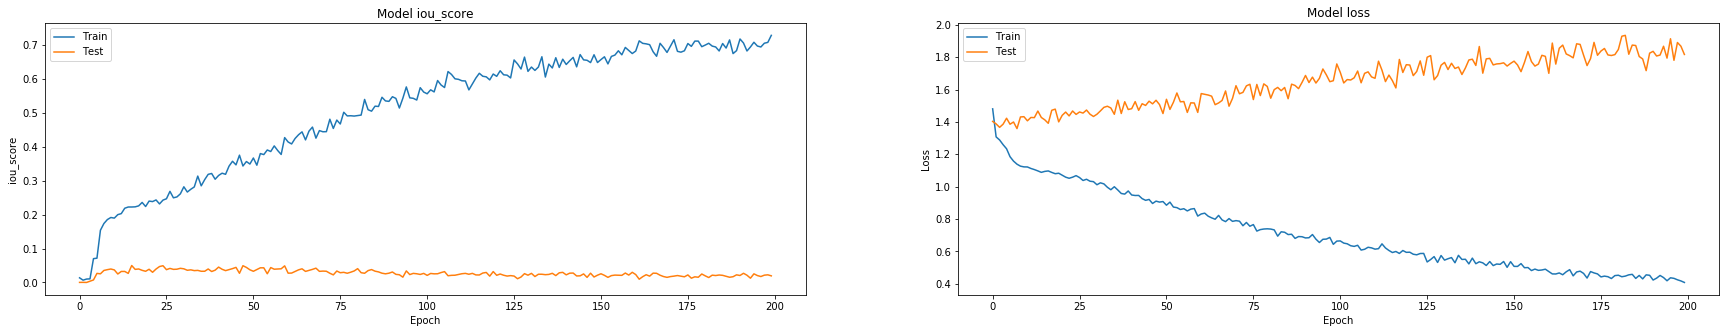

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

(512, 512, 3) (512, 512)


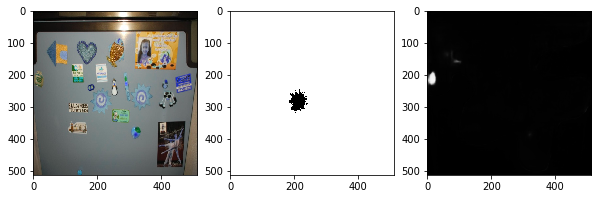

(512, 512, 3) (512, 512)


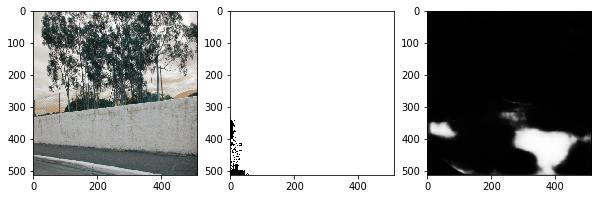

(512, 512, 3) (512, 512)


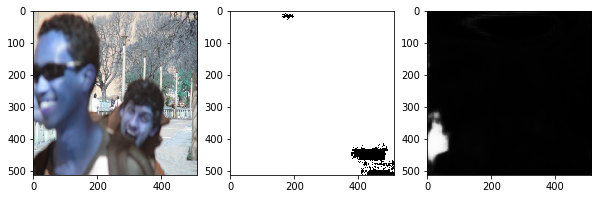

(512, 512, 3) (512, 512)


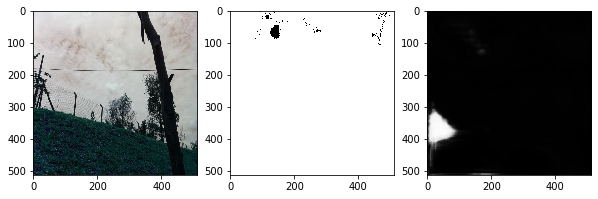

(512, 512, 3) (512, 512)


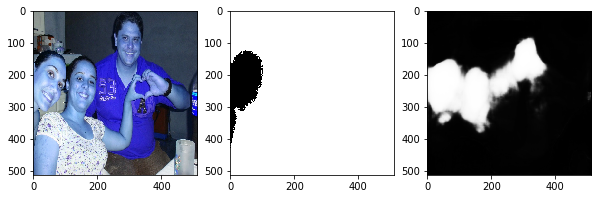

(512, 512, 3) (512, 512)


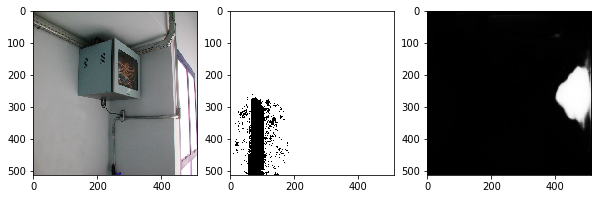

(512, 512, 3) (512, 512)


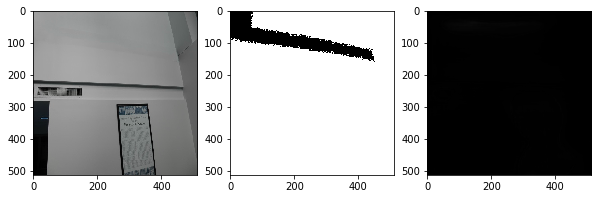

(512, 512, 3) (512, 512)


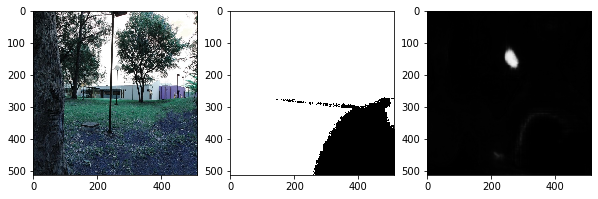

(512, 512, 3) (512, 512)


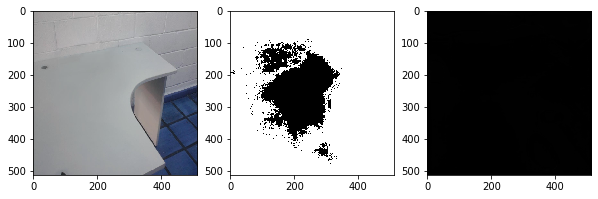

(512, 512, 3) (512, 512)


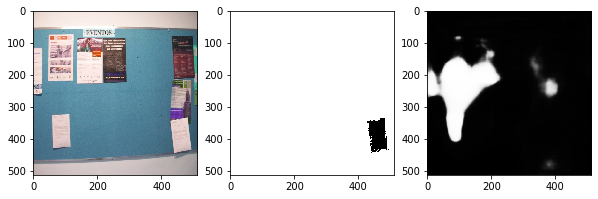

(512, 512, 3) (512, 512)


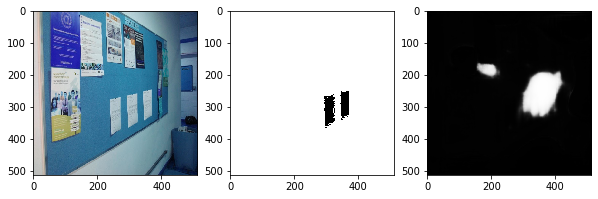

(512, 512, 3) (512, 512)


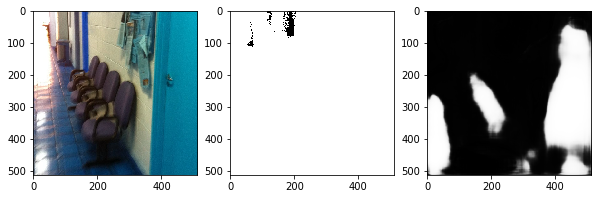

(512, 512, 3) (512, 512)


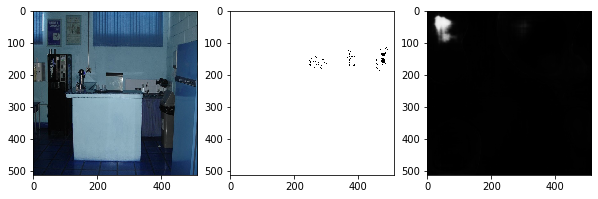

(512, 512, 3) (512, 512)


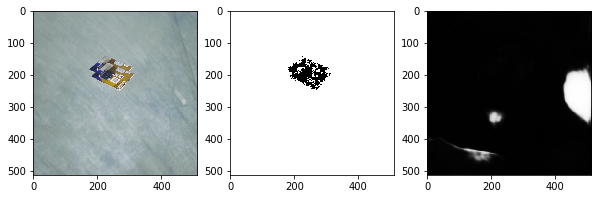

(512, 512, 3) (512, 512)


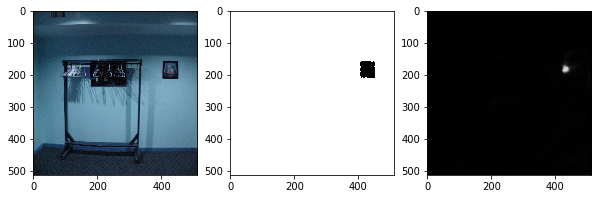

(512, 512, 3) (512, 512)


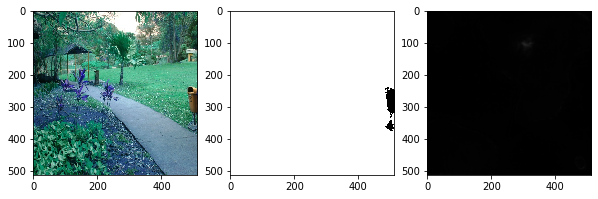

(512, 512, 3) (512, 512)


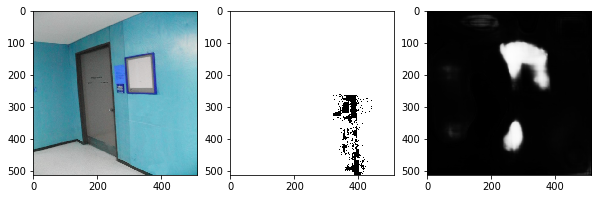

(512, 512, 3) (512, 512)


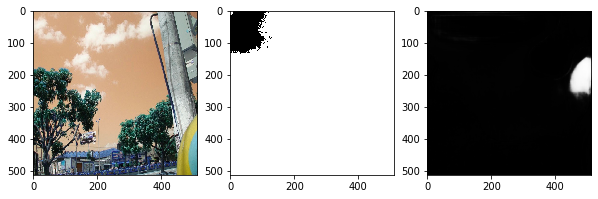

(512, 512, 3) (512, 512)


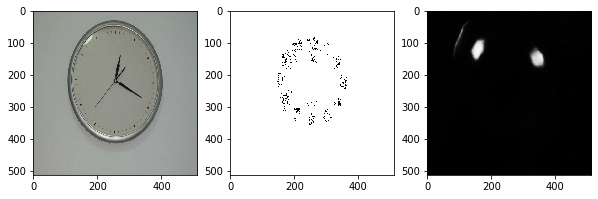

(512, 512, 3) (512, 512)


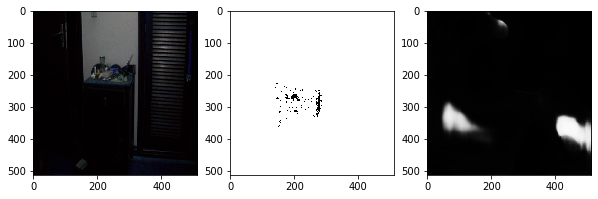

(512, 512, 3) (512, 512)


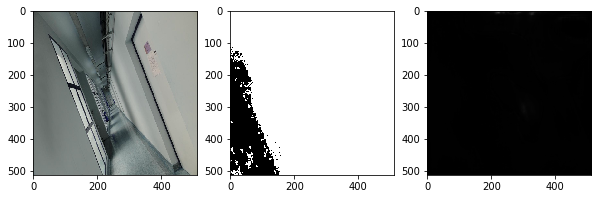

(512, 512, 3) (512, 512)


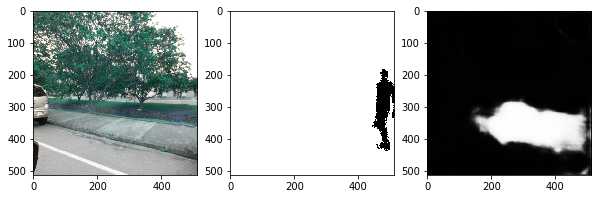

In [ ]:
dir_path = '900_images'
for p, i in enumerate(X_test):
    #original image
    image = cv2.imread(os.path.join(dir_path, i+'.jpg'), cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (512,512)) 
    
    #predicted segmentation map
    predicted  = model.predict(image[np.newaxis,:,:,:])
    
    #original segmentation map
    image_mask = cv2.imread(os.path.join(dir_path, i+'.mask.jpg'), cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (512,512))
    

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask, cmap='gray', vmax=1, vmin=0)
    plt.subplot(133)
    plt.imshow(predicted[0,:,:,0], cmap='gray', vmax=1, vmin=0)
    plt.show()